

# Anomaly Detection with GAN

- Anomaly Detection

- 2017년에 발표된 Unsupervised Anomaly Detection with Generative Adversarial Networks to Guide Marker Discovery라는 논문에서 AnoGAN이라는 모델

- https://arxiv.org/pdf/1703.05921.pdf

- 현재 경로 이미지 참고..... 이론

In [ ]:
# 

# library import


In [3]:
import tensorflow as tf

from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_recall_curve, average_precision_score
from scipy.interpolate import interp1d
from inspect import signature
from scipy.optimize import brentq

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os

import PIL
from tensorflow.keras import layers
import time
from scipy.stats import norm

from IPython import display

# data set import(mnist)

- Fashion-MNIST는 1채널 grayscale 데이터셋입니다. 그냥은 Convolution 연산이 되지 않으므로 채널방향 차원이 하나 늘어나도록 reshape하는 과정이 필요합니다. (주의) UNet 구조의 활용을 위해서 기존의 28 X 28 사이즈의 Fashion-MNIST 데이터 이미지를 32 X 32 로 패딩처리해 줄 필요가 있습니다.

In [4]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

train_data = (train_data - 127.5) / 127.5
test_data = (test_data - 127.5) / 127.5

from PIL import Image

# Fashion MNIST padding to 32 X 32
train_data_32 = np.zeros((train_data.shape[0], 32, 32)).astype('float32')
test_data_32 = np.zeros((test_data.shape[0], 32, 32)).astype('float32')     
train_data_32[:, 2:30, 2:30] = train_data
test_data_32[:, 2:30, 2:30] = test_data

# 1channel data reshape
train_data = train_data_32.reshape(train_data_32.shape[0], 32, 32, 1).astype('float32')
test_data = test_data_32.reshape(test_data_32.shape[0], 32, 32, 1).astype('float32')

print(train_data.shape)
print(test_data.shape)

4423680/4422102 [==============================] - 0s 0us/step
(60000, 32, 32, 1)
(10000, 32, 32, 1)


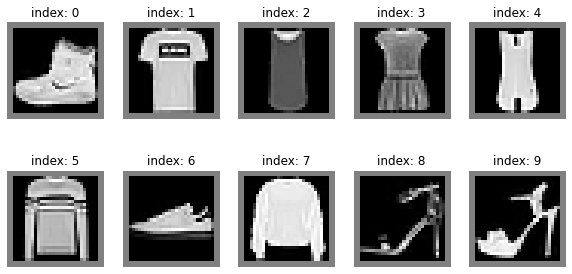

In [5]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_data[i].reshape(32, 32), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

############## 8번 라벨 bag 임의 로 삭제

In [6]:
def set_labels(labels):
    new_t_labels = []
    for old_label in labels:
        if old_label == 8:   # Bag:8
            new_t_labels.append([0])  # Bag을 이상치로 처리
        else:
            new_t_labels.append([1])  # 그 외의 경우는 정상치
             
    return np.array(new_t_labels)

In [7]:
bol_train_labels = set_labels(train_labels)
bol_test_labels = set_labels(test_labels)

In [8]:
# label 0을 anmaly data로
# 나머지는 nomaly data 로분류


normal_data = []
normal_labels = []
anomaly_data = []
anomaly_labels = []
for data, label in zip(train_data, bol_train_labels):
    if label == 0:
        anomaly_data.append(data)
        anomaly_labels.append(label)
    else:
        normal_data.append(data)
        normal_labels.append(label)
        
normal_data = np.array(normal_data)
normal_labels = np.array(normal_labels)
anomaly_data = np.array(anomaly_data)
anomaly_labels = np.array(anomaly_labels)

In [9]:
print(normal_data.shape, normal_labels.shape)
print(anomaly_data.shape, anomaly_labels.shape)

(54000, 32, 32, 1) (54000, 1)
(6000, 32, 32, 1) (6000, 1)


In [18]:
#train data / label은 0말 고 나머지
#test data /label은 0인 넘들.....

train_data = normal_data
bol_train_labels = normal_labels
test_data = tf.concat([test_data, anomaly_data], 0)
bol_test_labels = tf.concat([bol_test_labels, anomaly_labels], 0)

In [19]:
print(train_data.shape)
print(test_data.shape)

(54000, 32, 32, 1)
(22000, 32, 32, 1)


In [20]:
print(bol_train_labels.shape)
print(bol_test_labels.shape)

(54000, 1)
(22000, 1)


In [21]:
# train 라벨이 0 있는 지 혹시나 체크
for label in bol_train_labels:
    if label == 0:
        print(label)
print("Done")

Done


In [14]:
BUFFER_SIZE = 10000
BATCH_SIZE = 8

# from_tensor_slices tensor data set<으로

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, bol_train_labels))
# 
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data, bol_test_labels))
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [15]:
for data, label in train_dataset.take(1):
    print(label)

tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]], shape=(8, 1), dtype=int64)


In [17]:
for data, label in test_dataset.take(1):
    print(label)

tf.Tensor(
[[1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]], shape=(8, 1), dtype=int64)


# model

## generator

In [22]:
class Conv_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_block, self).__init__()
        self.conv_layer = tf.keras.Sequential([
            layers.Conv2D(num_filters, 3, strides=2, padding='same', use_bias=False,
                          kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
        ])
        
    def call(self, inputs, training=False):
        outputs = self.conv_layer(inputs)
        
        return outputs

In [23]:
class Conv_T_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_T_block, self).__init__()
        self.conv_T_layer = tf.keras.Sequential([
            layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same', use_bias=False,
                                   kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.ReLU(),
        ])
        
    def call(self, inputs, concat, training=False):
        upsample = self.conv_T_layer(inputs)
        outputs = tf.concat([upsample, concat], -1)
        
        return outputs

In [24]:
class Generator(tf.keras.Model):
    def __init__(self, num_output_channel=3):
        super(Generator, self).__init__()
        self.encoder_1 = Conv_block(64) # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2
        
        self.center = Conv_block(512) # 1
        
        self.decoder_4 = Conv_T_block(512) # 2
        self.decoder_3 = Conv_T_block(256) # 4
        self.decoder_2 = Conv_T_block(128) # 8
        self.decoder_1 = Conv_T_block(64) # 16
        
        self.output_layer = layers.Conv2DTranspose(num_output_channel, 1, strides=2, padding='same', use_bias=False, # 32
                                                   kernel_initializer=tf.random_normal_initializer(0., 0.02))
                
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # gen
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        de_4 = self.decoder_4(center, en_4)
        de_3 = self.decoder_3(de_4, en_3)
        de_2 = self.decoder_2(de_3, en_2)
        de_1 = self.decoder_1(de_2, en_1)
        
        outputs = self.output_layer(de_1)
        
        return outputs

## disciminator

In [27]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.encoder_1 = Conv_block(64) # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2
        
        self.center = Conv_block(100) # 1
        
        self.outputs = layers.Conv2D(1, 3, strides=1, padding='same',
                                          use_bias=False, activation='sigmoid')
    
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # dis
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        outputs = self.outputs(center)
        
        return outputs, center

## 전체 모델 구성

In [26]:
generator = Generator(num_output_channel=1)  # Generator가 32X32X1 짜리 이미지를 생성해야 합니다. 
discriminator = Discriminator()

## loss 함수

In [29]:
l2_loss = tf.keras.losses.MeanSquaredError()
l1_loss = tf.keras.losses.MeanAbsoluteError()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [30]:
def discriminator_loss(pred_real, pred_fake):
    real_loss = cross_entropy(tf.ones_like(pred_real), pred_real)
    fake_loss = cross_entropy(tf.zeros_like(pred_fake), pred_fake)
    
    total_dis_loss = (real_loss + fake_loss) * 0.5
    
    return total_dis_loss

In [31]:
def generator_loss(real_output, fake_output, input_data, gen_data, latent_first, latent_sec):
    w_adv = 1.
    w_context = 40.
    w_encoder = 1.
    
    adv_loss = cross_entropy(real_output, fake_output)
    context_loss = l1_loss(input_data, gen_data)
    encoder_loss = l2_loss(latent_first, latent_sec)
    
    total_gen_loss = w_adv * adv_loss + \
                     w_context * context_loss + \
                     w_encoder * encoder_loss
    
    return total_gen_loss

## optiminzer

In [32]:
# Optimizer 설정
generator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)

In [38]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## train

In [39]:
def train_step(images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(images, training=True)
        
        pred_real, feat_real = discriminator(images, training=True)
        pred_fake, feat_fake = discriminator(generated_images, training=True)

        gen_loss = generator_loss(pred_real, pred_fake,
                                  images, generated_images,
                                  feat_real, feat_fake)

        disc_loss = discriminator_loss(pred_real, pred_fake)        

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [40]:
checkpoint_path = os.path.join(os.getenv('HOME'),'lsg/data/ganomaly_skip_no_norm/ckpt')

if not os.path.isdir(checkpoint_path):
    os.makedirs(checkpoint_path)
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
max_epochs = 25
steps = 0

for epoch in range(max_epochs):
    start = time.time()

    for images, labels in train_dataset:
        steps += 1
        gen_loss, disc_loss = train_step(images)
        
        if steps % 100 == 0:
            print ('Steps : {}, \t Total Gen Loss : {}, \t Total Dis Loss : {}'.format(steps, gen_loss.numpy(), disc_loss.numpy()))
        
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_path)#수정....
        
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

Steps : 100, 	 Total Gen Loss : 30.974559783935547, 	 Total Dis Loss : 0.0007348734070546925
Steps : 200, 	 Total Gen Loss : 30.26750373840332, 	 Total Dis Loss : 0.003238727105781436
Steps : 300, 	 Total Gen Loss : 30.70307159423828, 	 Total Dis Loss : 0.0015529505908489227
Steps : 400, 	 Total Gen Loss : 31.103967666625977, 	 Total Dis Loss : 0.0013490122510120273
Steps : 500, 	 Total Gen Loss : 31.17817497253418, 	 Total Dis Loss : 0.0005106075550429523
Steps : 600, 	 Total Gen Loss : 32.68364334106445, 	 Total Dis Loss : 0.000861518201418221
Steps : 700, 	 Total Gen Loss : 28.976654052734375, 	 Total Dis Loss : 0.0005386686534620821
Steps : 800, 	 Total Gen Loss : 32.363807678222656, 	 Total Dis Loss : 0.000577768194489181
Steps : 900, 	 Total Gen Loss : 32.450050354003906, 	 Total Dis Loss : 0.0018523933831602335
Steps : 1000, 	 Total Gen Loss : 34.002601623535156, 	 Total Dis Loss : 0.0011352825677022338
Steps : 1100, 	 Total Gen Loss : 33.09938049316406, 	 Total Dis Loss : 0.000

Steps : 8900, 	 Total Gen Loss : 31.539316177368164, 	 Total Dis Loss : 0.00034143580705858767
Steps : 9000, 	 Total Gen Loss : 35.41230392456055, 	 Total Dis Loss : 0.000753417203668505
Steps : 9100, 	 Total Gen Loss : 30.61956024169922, 	 Total Dis Loss : 0.0009030551882460713
Steps : 9200, 	 Total Gen Loss : 33.364959716796875, 	 Total Dis Loss : 0.0005611955421045423
Steps : 9300, 	 Total Gen Loss : 31.718870162963867, 	 Total Dis Loss : 0.00017349651898257434
Steps : 9400, 	 Total Gen Loss : 32.96361541748047, 	 Total Dis Loss : 0.0005632448010146618
Steps : 9500, 	 Total Gen Loss : 31.46816635131836, 	 Total Dis Loss : 0.0005479869432747364
Steps : 9600, 	 Total Gen Loss : 30.694217681884766, 	 Total Dis Loss : 0.0004528373247012496
Steps : 9700, 	 Total Gen Loss : 30.940595626831055, 	 Total Dis Loss : 0.0005589798092842102
Steps : 9800, 	 Total Gen Loss : 32.44208908081055, 	 Total Dis Loss : 0.000742570380680263
Steps : 9900, 	 Total Gen Loss : 32.78911209106445, 	 Total Dis L

Steps : 17600, 	 Total Gen Loss : 30.50650405883789, 	 Total Dis Loss : 0.0009151804260909557
Steps : 17700, 	 Total Gen Loss : 31.176546096801758, 	 Total Dis Loss : 0.016383877024054527
Steps : 17800, 	 Total Gen Loss : 33.28278732299805, 	 Total Dis Loss : 0.0002875876671168953
Steps : 17900, 	 Total Gen Loss : 33.561866760253906, 	 Total Dis Loss : 0.0003887089842464775
Steps : 18000, 	 Total Gen Loss : 33.23715591430664, 	 Total Dis Loss : 0.0003024609759449959
Steps : 18100, 	 Total Gen Loss : 30.796428680419922, 	 Total Dis Loss : 0.0005613599205389619
Steps : 18200, 	 Total Gen Loss : 31.744915008544922, 	 Total Dis Loss : 0.03600145876407623
Steps : 18300, 	 Total Gen Loss : 32.94775390625, 	 Total Dis Loss : 0.0008923446293920279
Steps : 18400, 	 Total Gen Loss : 34.09077453613281, 	 Total Dis Loss : 0.00036813082988373935
Steps : 18500, 	 Total Gen Loss : 30.129867553710938, 	 Total Dis Loss : 0.0006896270788274705
Steps : 18600, 	 Total Gen Loss : 33.39690017700195, 	 Total

Steps : 26300, 	 Total Gen Loss : 32.5034065246582, 	 Total Dis Loss : 0.0007497017504647374
Steps : 26400, 	 Total Gen Loss : 30.448806762695312, 	 Total Dis Loss : 0.0010241540148854256
Steps : 26500, 	 Total Gen Loss : 29.264389038085938, 	 Total Dis Loss : 0.0008037680527195334
Steps : 26600, 	 Total Gen Loss : 30.541257858276367, 	 Total Dis Loss : 0.0009344509453512728
Steps : 26700, 	 Total Gen Loss : 31.185640335083008, 	 Total Dis Loss : 0.0010034403530880809
Steps : 26800, 	 Total Gen Loss : 33.95658874511719, 	 Total Dis Loss : 0.0003410087083466351
Steps : 26900, 	 Total Gen Loss : 28.35906219482422, 	 Total Dis Loss : 0.0005934683722443879
Steps : 27000, 	 Total Gen Loss : 32.86634063720703, 	 Total Dis Loss : 0.0004330913652665913
Time for epoch 4 is 543.0965387821198 sec
Steps : 27100, 	 Total Gen Loss : 31.007160186767578, 	 Total Dis Loss : 0.0007003765786066651
Steps : 27200, 	 Total Gen Loss : 33.130027770996094, 	 Total Dis Loss : 0.000553944380953908
Steps : 27300,

Steps : 34900, 	 Total Gen Loss : 31.910289764404297, 	 Total Dis Loss : 0.0018472003284841776
Steps : 35000, 	 Total Gen Loss : 30.68623924255371, 	 Total Dis Loss : 0.0015382550191134214
Steps : 35100, 	 Total Gen Loss : 33.238006591796875, 	 Total Dis Loss : 0.0003223716630600393
Steps : 35200, 	 Total Gen Loss : 30.55084228515625, 	 Total Dis Loss : 0.005204136483371258
Steps : 35300, 	 Total Gen Loss : 30.296022415161133, 	 Total Dis Loss : 0.0014926684089004993
Steps : 35400, 	 Total Gen Loss : 30.468172073364258, 	 Total Dis Loss : 0.0007345216581597924
Steps : 35500, 	 Total Gen Loss : 30.907997131347656, 	 Total Dis Loss : 0.0008722483762539923
Steps : 35600, 	 Total Gen Loss : 30.526025772094727, 	 Total Dis Loss : 0.0003281162353232503
Steps : 35700, 	 Total Gen Loss : 32.968963623046875, 	 Total Dis Loss : 0.0001617273810552433
Steps : 35800, 	 Total Gen Loss : 32.32097244262695, 	 Total Dis Loss : 0.0002358811761951074
Steps : 35900, 	 Total Gen Loss : 34.26161193847656, 	

Steps : 43600, 	 Total Gen Loss : 31.020402908325195, 	 Total Dis Loss : 0.009797366335988045
Steps : 43700, 	 Total Gen Loss : 31.499317169189453, 	 Total Dis Loss : 0.0004553029721137136
Steps : 43800, 	 Total Gen Loss : 31.67433738708496, 	 Total Dis Loss : 0.01623028889298439
Steps : 43900, 	 Total Gen Loss : 34.80731201171875, 	 Total Dis Loss : 0.0005827970453538001
Steps : 44000, 	 Total Gen Loss : 32.52281188964844, 	 Total Dis Loss : 0.15332633256912231
Steps : 44100, 	 Total Gen Loss : 31.227157592773438, 	 Total Dis Loss : 0.000663430371787399
Steps : 44200, 	 Total Gen Loss : 32.540489196777344, 	 Total Dis Loss : 0.00035636546090245247
Steps : 44300, 	 Total Gen Loss : 34.251708984375, 	 Total Dis Loss : 0.00019279606931377202
Steps : 44400, 	 Total Gen Loss : 30.07342529296875, 	 Total Dis Loss : 0.002920759841799736
Steps : 44500, 	 Total Gen Loss : 31.965923309326172, 	 Total Dis Loss : 0.0005032876506447792
Steps : 44600, 	 Total Gen Loss : 33.17439270019531, 	 Total D

Steps : 52300, 	 Total Gen Loss : 30.394563674926758, 	 Total Dis Loss : 0.0037002312019467354
Steps : 52400, 	 Total Gen Loss : 31.427053451538086, 	 Total Dis Loss : 0.0014927656156942248
Steps : 52500, 	 Total Gen Loss : 33.206722259521484, 	 Total Dis Loss : 8.540348790120333e-05
Steps : 52600, 	 Total Gen Loss : 35.15335464477539, 	 Total Dis Loss : 0.00029560650000348687
Steps : 52700, 	 Total Gen Loss : 31.32646369934082, 	 Total Dis Loss : 0.001049028243869543
Steps : 52800, 	 Total Gen Loss : 33.19643783569336, 	 Total Dis Loss : 5.884052370674908e-05
Steps : 52900, 	 Total Gen Loss : 29.581222534179688, 	 Total Dis Loss : 0.0015012247022241354
Steps : 53000, 	 Total Gen Loss : 33.43572235107422, 	 Total Dis Loss : 0.0004150604654569179
Steps : 53100, 	 Total Gen Loss : 30.62825584411621, 	 Total Dis Loss : 0.010195535607635975
Steps : 53200, 	 Total Gen Loss : 33.98604965209961, 	 Total Dis Loss : 0.00046682701213285327
Steps : 53300, 	 Total Gen Loss : 33.81538772583008, 	 T

Steps : 60900, 	 Total Gen Loss : 34.395938873291016, 	 Total Dis Loss : 0.0002197232679463923
Steps : 61000, 	 Total Gen Loss : 33.1950798034668, 	 Total Dis Loss : 0.0002660469035618007
Steps : 61100, 	 Total Gen Loss : 32.84169387817383, 	 Total Dis Loss : 0.0004048227274324745
Steps : 61200, 	 Total Gen Loss : 36.194061279296875, 	 Total Dis Loss : 0.0030915781389921904
Steps : 61300, 	 Total Gen Loss : 33.076751708984375, 	 Total Dis Loss : 0.000258435815339908
Steps : 61400, 	 Total Gen Loss : 31.651229858398438, 	 Total Dis Loss : 0.00025839172303676605
Steps : 61500, 	 Total Gen Loss : 33.43635177612305, 	 Total Dis Loss : 0.0002446325379423797
Steps : 61600, 	 Total Gen Loss : 33.887062072753906, 	 Total Dis Loss : 0.00026441464433446527
Steps : 61700, 	 Total Gen Loss : 36.24104309082031, 	 Total Dis Loss : 0.006903739180415869
Steps : 61800, 	 Total Gen Loss : 33.688785552978516, 	 Total Dis Loss : 0.001027360325679183
Steps : 61900, 	 Total Gen Loss : 32.84803009033203, 	 T

## evalutaion

In [42]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

In [43]:
def _evaluate(test_dataset, set_lambda=0.9):
    an_scores = []
    gt_labels = []
    for step, (x_batch_train, y_batch_train) in enumerate(test_dataset):
        generated_images = generator(x_batch_train, training=True)
        _, feat_real = discriminator(x_batch_train, training=True)
        _, feat_fake = discriminator(generated_images, training=True)

        generated_images, feat_real, feat_fake = generated_images.numpy(), feat_real.numpy(), feat_fake.numpy()        

        rec = abs(x_batch_train - generated_images)
        lat = (feat_real - feat_fake) ** 2

        rec = tf.reduce_sum(rec, [1,2,3])
        lat = tf.reduce_sum(lat, [1,2,3])
        
        error = (set_lambda * tf.cast(rec, tf.float32)) + ((1 - set_lambda) * tf.cast(lat, tf.float32))
        
        an_scores.append(error)
        gt_labels.append(y_batch_train)
        
    an_scores = np.concatenate(an_scores, axis=0).reshape([-1])
    gt_labels = np.concatenate(gt_labels, axis=0).reshape([-1])
    
    an_scores = (an_scores - np.amin(an_scores)) / (np.amax(an_scores) - np.amin(an_scores))
    
    return an_scores, gt_labels

In [44]:
an_scores, gt_labels = _evaluate(test_dataset)

print(len(an_scores), len(gt_labels))

16000 16000


In [45]:
normal = []
anormaly = []
for score, label in zip(an_scores, gt_labels):
    if label == 0:
        anormaly.append(score)
    else:
        normal.append(score)

normal = np.array(normal)
print(normal.shape)
anormaly = np.array(anormaly)
print(anormaly.shape)

(9000,)
(7000,)


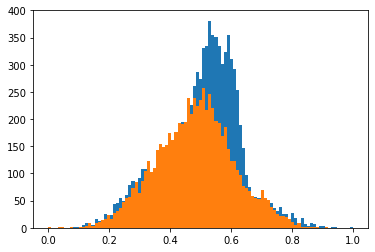

In [46]:
plt.hist(normal, bins=np.linspace(0.0, 1.0, num=100))
plt.hist(anormaly, bins=np.linspace(0.0, 1.0, num=100))
plt.show()

0.5050549 0.48207346
0.1276761 0.12728648


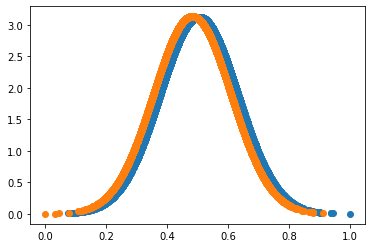

In [47]:
plt.plot(normal, norm.pdf(normal, np.mean(normal), np.std(normal)), 'o')
plt.plot(anormaly, norm.pdf(anormaly, np.mean(anormaly), np.std(anormaly)), 'o')

print(np.mean(normal), np.mean(anormaly))
print(np.std(normal), np.std(anormaly))

In [48]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]